In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Neural Network With NAICS Embedding Layer + Random Unseen Codes
This is like 04, but the training data is randomized to inject the unseen embedding code (1) into the data.

Add NAICS embedding to model.  Only add the baseline NAICS (not higher levels in the hierarchy).  

Use the dataset with no missing values. 

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model

In [7]:
importlib.reload(sbnn_model)

<module 'sba_nn.sba_nn.sbnn_model' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_model.py'>

## Input Data

In [8]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [9]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [10]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)
naics_max_levels

{'NAICS': 1170,
 'NAICS_5': 764,
 'NAICS_4': 345,
 'NAICS_3': 107,
 'NAICS_sector': 21}

##### Features

In [11]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [12]:
# NAICS feature - all levels except NAICS_5
features_naics = ['NAICS', 'NAICS_4', 'NAICS_3', 'NAICS_sector']
features_naics_max_levels  = [naics_max_levels[n] for n in features_naics]
features_naics_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_naics]

In [13]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170, 345, 107, 21]
[8, 4, 4, 2]


## Data Adjustment
Inject "1" values into train

In [14]:
for i, n in enumerate(features_naics):
    adj_index, _ = train_test_split(sba_loans[sba_loans['dset'] == 'train'].index, 
                                    train_size=0.10, random_state=645 + i)
    sba_loans.loc[adj_index, n] = 1

In [15]:
# Show unseen counts - expect some in train now!
pd.crosstab(sba_loans['dset'], sba_loans['NAICS'] == 1)

NAICS,False,True
dset,,
test,95552,57496
train,402164,44684
val,95593,11


##### Datasets for train, validation

In [16]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric].set_index('LoanNr_ChkDgt').sort_index()

In [17]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 10), y:(446848,)


In [18]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 10), y:(95604,)


In [19]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


In [20]:
X_naics = [sba_loans[['dset', 'LoanNr_ChkDgt', n]].set_index('LoanNr_ChkDgt').sort_index() \
           for n in features_naics]

In [21]:
X_naics_train = [Xn[Xn['dset'] == 'train'].drop(columns='dset') for Xn in X_naics]
X_naics_val =  [Xn[Xn['dset'] == 'val'].drop(columns='dset') for Xn in X_naics]

## Create, Fit Model

In [22]:
this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         features_naics_max_levels,
                                         features_naics_emb_dim,
                                         naics_embedding_names = features_naics,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)

2024-05-16 22:31:08.207218: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-16 22:31:08.207291: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-16 22:31:08.207320: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-16 22:31:08.207388: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-16 22:31:08.207421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_naics_00 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_01 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_02 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                            

In [24]:
this_history = this_model.fit([X_train] + X_naics_train, y_train,
                              validation_data=([X_val] + X_naics_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs)

Epoch 1/20


2024-05-16 22:31:11.816419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13964/13964 [==============================] - ETA: 0s - loss: 0.4626 - auc: 0.3368 - auc_1: 0.6998

2024-05-16 22:38:14.389528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13964/13964 [==============================] - 453s 31ms/step - loss: 0.4626 - auc: 0.3368 - auc_1: 0.6998 - val_loss: 0.4535 - val_auc: 0.3735 - val_auc_1: 0.7234
Epoch 2/20
13964/13964 [==============================] - 303s 22ms/step - loss: 0.4547 - auc: 0.3587 - auc_1: 0.7161 - val_loss: 0.4519 - val_auc: 0.3774 - val_auc_1: 0.7261
Epoch 3/20
13964/13964 [==============================] - 307s 22ms/step - loss: 0.4523 - auc: 0.3665 - auc_1: 0.7214 - val_loss: 0.4507 - val_auc: 0.3821 - val_auc_1: 0.7296
Epoch 4/20
13964/13964 [==============================] - 3850s 276ms/step - loss: 0.4513 - auc: 0.3709 - auc_1: 0.7235 - val_loss: 0.4501 - val_auc: 0.3829 - val_auc_1: 0.7306
Epoch 5/20
13964/13964 [==============================] - 1152s 83ms/step - loss: 0.4503 - auc: 0.3736 - auc_1: 0.7252 - val_loss: 0.4507 - val_auc: 0.3857 - val_auc_1: 0.7309
Epoch 6/20
13964/13964 [==============================] - 1141s 82ms/step - loss: 0.4498 - auc: 0.3750 - auc_1: 0.7263 - val_loss: 0.

In [25]:
importlib.reload(sbnn_model)

<module 'sba_nn.sba_nn.sbnn_model' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_model.py'>

In [26]:
this_history_df = sbnn_model.process_history(this_history)

In [27]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('06_REPORT_fit_history.csv'))

<Axes: >

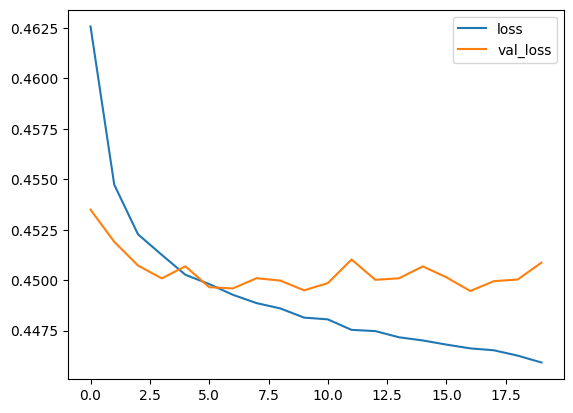

In [28]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

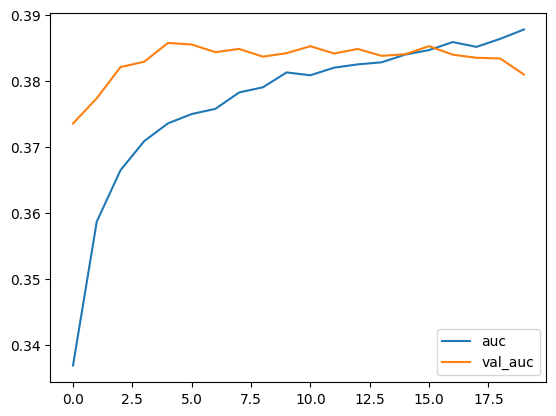

In [29]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

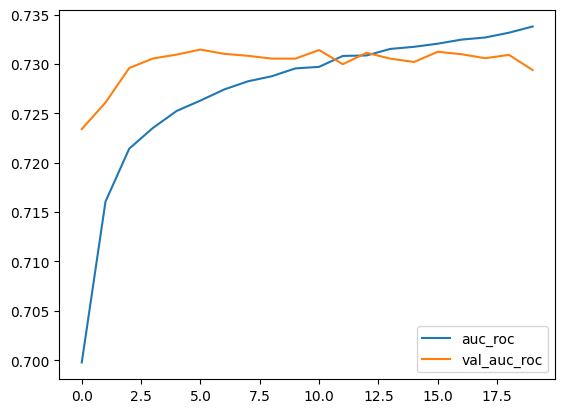

In [30]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [31]:
this_model.save(Path(setup.temp_path).joinpath('06_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [32]:
X_naics = [sba_loans[['dset', 'LoanNr_ChkDgt', n]].set_index('LoanNr_ChkDgt').sort_index() \
           for n in features_naics]

In [33]:
all_predictions = this_model.predict([X.drop(columns='dset')] +
                                     [Xn.drop(columns='dset') for Xn in X_naics])

   96/21735 [..............................] - ETA: 34s

2024-05-17 02:53:07.048167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21735/21735 [==============================] - 50s 2ms/step


In [34]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [35]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.00000,0.32889
target,0.32889,1.00000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [36]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [37]:
thresh_tune_data = sbnn_metrics.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [38]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
10,0.20,0.456528
11,0.22,0.456262
9,0.18,0.453284


In [39]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.2

##### Append binary predictions to probability predictions

In [40]:
all_predictions_df['predict_bin'] = sbnn_metrics.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [41]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.562203
1    0.437797
Name: proportion, dtype: float64

In [42]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('06_DATA_predictions.parquet'))

## Metrics

In [43]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('06_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.648751,0.449291,0.328554,0.710320,0.377556,0.730136,NaN
1,train,0.651808,0.456528,0.333606,0.722887,0.397406,0.739910,NaN
2,val,0.647170,0.450117,0.329837,0.708472,0.381097,0.729439,NaN
0,test,0.644966,0.446540,0.326767,0.704919,0.377912,0.726207,0.0
1,test,0.655042,0.453935,0.331563,0.719473,0.377036,0.737066,1.0
